In [100]:
import os, gc, sys
import pygrib
import regionmask
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import multiprocessing as mp
import matplotlib.pyplot as plt 
import matplotlib as mpl

from glob import glob
from numpy import trapz
from scipy.integrate import simps
from sklearn.metrics import auc as auc_calc
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'

In [160]:
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 
cwa = 'SLC'#sys.argv[1]
fhr_start, fhr_end, fhr_step = 24, 168, 24

ver = '4p0'
start_date = datetime(2020, 11, 1, 0)
end_date = datetime(2021, 1, 31, 0)

# start_date = datetime(2020, 10, 1, 0)
# end_date = datetime(2020, 12, 1, 0)

interval = 24

produce_thresholds = [0.01, 0.25, 0.5, 1., 2.]#, 4.]
bint, bins_custom = 100/10, None

cwa_bounds = {
    'WESTUS':[30, 50, -130, -100],
    'SEW':[46.0, 49.0, -125.0, -120.5],
    'SLC':[37.0, 42.0, -114.0, -110],
    'MSO':[44.25, 49.0, -116.75, -112.25],
    'MTR':[35.75, 38.75, -123.5, -120.25],}

n_events = 3
cx = None #8 if cwa == 'WESTUS' else 4
cy = cx
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 

In [161]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
fig_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/'
os.makedirs(tmp_dir, exist_ok=True)

In [162]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))

if not os.path.isfile(urma_dir + 'agg/urma_agg.nc'):
    pass 
    #print('URMA aggregate not found')

else:
    #print('Getting URMA aggregate from file')
    urma = xr.open_dataset(urma_dir + 'agg/urma_agg.new.nc')['apcp24h_mm']

urma = urma/25.4
urma = urma.rename('apcp24h_in')
lons, lats = urma.lon, urma.lat

In [163]:
urma.valid[0].values, urma.valid[-1].values

(numpy.datetime64('2020-11-01T12:00:00.000000000'),
 numpy.datetime64('2021-01-31T18:00:00.000000000'))

# Masking with regionmask and zones shapefile

In [164]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA').reset_index()[['CWA', 'geometry']]
_cwas = cwas.copy()

if cwa == 'WESTUS':
    _cwas['CWA'] = 'WESTUS'
    _cwas = _cwas.dissolve(by='CWA').reset_index()
    bounds = _cwas.total_bounds
else:
    bounds = _cwas[_cwas['CWA'] == cwa].bounds.values[0]
    
print(bounds)
    
lons, lats = urma.lon, urma.lat
mask = regionmask.mask_3D_geopandas(_cwas, lons, lats).rename({'region':'cwa'})
mask['cwa'] = _cwas.iloc[mask.cwa]['CWA'].values.astype(str)
mask = mask.sel(cwa=cwa)
mask

[-114.05297852   36.9997139  -109.87389374   42.00161362]


<xarray.DataArray (y: 1051, x: 1132)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1044 1045 1046 1047 1048 1049 1050
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1125 1126 1127 1128 1129 1130 1131
    lat      (y, x) float32 26.477743 26.483274 26.4888 ... 52.766827 52.767593
    lon      (y, x) float32 -128.18382 -128.15907 ... -100.213776 -100.18081
    cwa      <U3 'SLC'

In [165]:
idx = np.where(
    (urma.lat >= bounds[1]) & (urma.lat <= bounds[3]) &
    (urma.lon >= bounds[0]) & (urma.lon <= bounds[2]))

mask = mask.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.transpose('valid', 'y', 'x')

In [166]:
_mask, _urma = xr.broadcast(mask, urma)
_urma = xr.where(_mask, _urma, np.nan)

N = xr.where(~np.isnan(_urma), 1, 0).sum()

for threshold in [0.01, 0.10, 0.25, 0.50, 1.0, 2.0, 4.0]:
    
    count = xr.where(_urma > threshold, 1, 0).sum()
    freq = count/N
    
#     print('%.2f\t%d\t%d\t%.3f'%(threshold, N, count, freq))
#     print('%d\t'%count, end='')
    print('%.6f\t'%freq, end='')

N

0.244781	0.068328	0.020389	0.004980	0.000518	0.000002	0.000000	

<xarray.DataArray ()>
array(10523190)
Coordinates:
    cwa      <U3 'SLC'

In [168]:
def extract_pqpf_verif_stats(_fhr, _urma):

    nbm_file = glob(nbm_dir + 'extract/nbm_probx_fhr%03d.nc'%_fhr)[0]
    print(nbm_file)
    
    # Subset the threshold value
    nbm = xr.open_dataset(nbm_file)['probx'].sel(
    y=slice(idx[0].min(), idx[0].max()),
    x=slice(idx[1].min(), idx[1].max()))

    # Subset the times
    nbm_time = nbm.valid
    urma_time = _urma.valid
    time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
    time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
    time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])
    date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
    date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

    _nbm = nbm.sel(valid=time_match)
    _urma = _urma.sel(valid=time_match)
    nbm_mask, _nbm = xr.broadcast(mask, _nbm)
    urma_mask, _urma = xr.broadcast(mask, _urma)

    _nbm_masked = xr.where(nbm_mask, _nbm, np.nan)
    _urma_masked = xr.where(urma_mask, _urma, np.nan)
        
    data = []
    
    for thresh in produce_thresholds[:1]:
        
        print('Processing f%03d %.2f"'%(_fhr, thresh))

        _nbm_masked_select = _nbm_masked.sel(threshold=thresh)/100
        
        bins = np.arange(0, 101, 10)
        
        # We need to count ONLY WHERE THE MASK IS NOT NAN
        
        N = xr.where(~np.isnan(_nbm_masked_select), 1, 0).sum()
        n = xr.where(_urma_masked > thresh, 1, 0).sum()
        o = n/N
        uncertainty = o * (1 - o)
        
        reliability_inner = []
        resolution_inner = []
        reliability_diagram = []
        roc_diagram = []
        roc_score = []

        for i, bounds in enumerate(zip(bins[:-1], bins[1:])):

            left, right = np.array(bounds)/100
            center = round(np.mean([left, right]), 2)
            
            fk = xr.where((_nbm_masked_select > left) & (_nbm_masked_select <= right), _nbm_masked_select, np.nan)
            nk = xr.where((_nbm_masked_select > left) & (_nbm_masked_select <= right), 1, 0).sum(dim=['x', 'y'])

            ok_count = xr.where((_nbm_masked_select > left) & (_nbm_masked_select <= right) & (_urma_masked > thresh), 1, 0).sum(['x', 'y'])
            ok_xy = ok_count/nk
            
            reliability_diagram.append([center, ok_xy.mean().values])
            
            nk = nk.sum()
            ok_count = ok_count.sum()
            ok = ok_count/nk
                        
            #        3D          1D     3D   1D
            _reliability_inner = nk * ((fk - ok)**2)
            _reliability_inner['center'] = left
            reliability_inner.append(_reliability_inner)

            #        1D         1D     1D   1D
            _resolution_inner = nk * ((ok - o)**2)
            _resolution_inner['center'] = left
            resolution_inner.append(_resolution_inner)
                                    
            hit = xr.where((_nbm_masked_select > left) & (_urma_masked > thresh), 1, 0).sum(dim='valid')
            false_alarm = xr.where((_nbm_masked_select > left) & (_urma_masked <= thresh), 1, 0).sum(dim='valid')
            
            observed_yes = xr.where(_urma_masked > thresh, 1, 0).sum(dim='valid')
            observed_no = xr.where(_urma_masked <= thresh, 1, 0).sum(dim='valid')
                        
            forecasted_yes = xr.where(_nbm_masked_select > left, 1, 0).sum(dim='valid')
            
            hit_rate = hit/observed_yes
            false_alarm_rate = false_alarm/observed_no
            false_alarm_ratio = false_alarm/forecasted_yes
            
            freq_bias = forecasted_yes/observed_yes
                                                
            a_ref = (observed_yes * forecasted_yes) / nk
            miss = xr.where((_nbm_masked_select <= left) & (_urma_masked > thresh), 1, 0).sum(dim='valid')
            ets = (hit - a_ref) / (hit - a_ref + false_alarm + miss)
            
            false_alarm_rate['center'] = center
            hit_rate['center'] = center
            roc_score.append([false_alarm_rate, hit_rate])
            
            roc_diagram.append([false_alarm_rate.mean().values, hit_rate.mean().values, 
                                left, false_alarm_ratio.mean().values, ets.mean().values, 
                                freq_bias.mean().values])
        
        reliability_inner = xr.concat(reliability_inner, dim='center')
        reliability_inner = xr.where(mask, reliability_inner.sum(dim='center'), np.nan)
        
        reliability = (1/N) * reliability_inner
        reliability = reliability.mean(dim='valid')
        
        resolution = (1/N) * xr.concat(resolution_inner, dim='center').sum(dim='center')
                
        brier = reliability - resolution + uncertainty
        brier_score = brier.mean().values
        
        brier_skill = 1 - (brier/o)
        
        brier_skill_score = xr.where(~np.isinf(brier_skill), brier_skill, np.nan).mean().values
        
        brier = brier.rename('brier')
        brier_skill = brier_skill.rename('brier_skill')
        
        reliability_diagram = np.array(reliability_diagram).T
        roc_diagram = np.array(roc_diagram).T
                
        ob_rel_freq = xr.DataArray(reliability_diagram[1],
                                   dims={'center':reliability_diagram[0]-.05}, coords={'center':reliability_diagram[0]-.05})
                        
        far = xr.DataArray(roc_diagram[0], dims={'center':roc_diagram[2]}, coords={'center':roc_diagram[2]})
        hr = xr.DataArray(roc_diagram[1], dims={'center':roc_diagram[2]}, coords={'center':roc_diagram[2]})
                
        faratio = xr.DataArray(roc_diagram[3], dims={'center':roc_diagram[2]}, coords={'center':roc_diagram[2]})
        ets = xr.DataArray(roc_diagram[4], dims={'center':roc_diagram[2]}, coords={'center':roc_diagram[2]})
        freq_bias = xr.DataArray(roc_diagram[5], dims={'center':roc_diagram[2]}, coords={'center':roc_diagram[2]})
        
        data_merge = xr.merge([brier_skill.mean(dim=['x', 'y'])])

        # Need to figure out reliability scaling and add in here as (x, y)
        data_merge['n_events'] = observed_yes.sum(dim=['x', 'y'])
        data_merge['ets'] = ets
        data_merge['freq_bias'] = freq_bias
        data_merge['hit_rate'] = hr
        data_merge['false_alarm_rate'] = far
        data_merge['false_alarm_ratio'] = faratio
        data_merge['ob_rel_freq'] = ob_rel_freq

        data.append(data_merge)
        
        del fk, nk, ok_count, ok, reliability, reliability_inner, resolution
        del brier, brier_skill, brier_score, brier_skill_score, roc_diagram, reliability_diagram
        gc.collect()

    gc.collect()
                                        
    return xr.concat(data, dim='thresh')

test = extract_pqpf_verif_stats(24, urma)
test

/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc
Processing f024 0.01"
Processing f024 0.25"
Processing f024 0.50"
Processing f024 1.00"
Processing f024 2.00"


<xarray.Dataset>
Dimensions:            (center: 10, thresh: 5)
Coordinates:
  * center             (center) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
    cwa                <U3 'SLC'
    threshold          (thresh) float64 0.01 0.25 0.5 1.0 2.0
    fhr                int64 24
    interval           int64 24
Dimensions without coordinates: thresh
Data variables:
    brier_skill        (thresh) float64 0.4488 0.264 0.2112 0.1571 0.0002607
    n_events           (thresh) int64 2473199 195430 46749 4814 22
    ets                (thresh, center) float64 0.3324 0.4492 0.4611 ... nan nan
    freq_bias          (thresh, center) float64 2.927 1.408 1.112 ... 0.0 0.0
    hit_rate           (thresh, center) float64 0.9321 0.7337 0.6606 ... 0.0 0.0
    false_alarm_rate   (thresh, center) float64 0.5764 0.1915 0.1273 ... 0.0 0.0
    false_alarm_ratio  (thresh, center) float64 0.6577 0.4514 0.3806 ... nan nan
    ob_rel_freq        (thresh, center) float64 0.1541 nan 0.3959 ... nan nan

/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc
Processing f024 0.01"
Processing f024 0.25"
Processing f024 0.50"
Processing f024 1.00"
Processing f024 2.00"


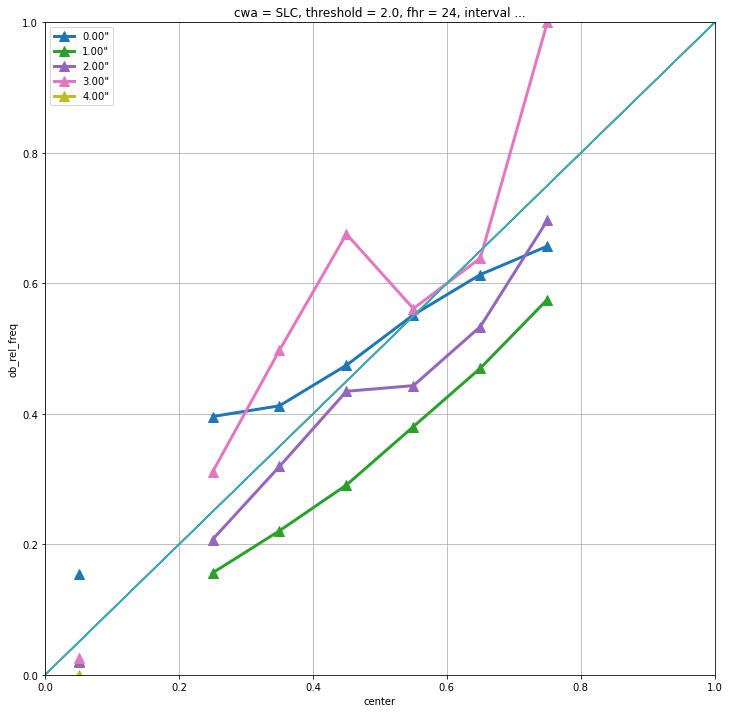

In [169]:
test = extract_pqpf_verif_stats(24, urma)

ob_rel_freq = test['ob_rel_freq']
ob_rel_freq['center'] = ob_rel_freq['center'] + 0.05
plt.figure(figsize=(12, 12), facecolor='w')
for i in ob_rel_freq.thresh:
    ob_rel_freq.sel(thresh=i).plot(linewidth=3, marker='^', markersize=10, label='%.2f"'%i)
    plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1))
    plt.grid()
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [ ]:
test = extract_pqpf_verif_stats(48, urma)

ob_rel_freq = test['ob_rel_freq']
ob_rel_freq['center'] = ob_rel_freq['center'] + 0.05
plt.figure(figsize=(12, 12), facecolor='w')
for i in ob_rel_freq.thresh:
    ob_rel_freq.sel(thresh=i).plot(linewidth=3, marker='^', markersize=10, label='%.2f"'%i)
    plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1))
    plt.grid()
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [ ]:
test = extract_pqpf_verif_stats(72, urma)

ob_rel_freq = test['ob_rel_freq']
ob_rel_freq['center'] = ob_rel_freq['center'] + 0.05
plt.figure(figsize=(12, 12), facecolor='w')
for i in ob_rel_freq.thresh:
    ob_rel_freq.sel(thresh=i).plot(linewidth=3, marker='^', markersize=10, label='%.2f"'%i)
    plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1))
    plt.grid()
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [ ]:
fhrs = np.arange(fhr_start, fhr_end+1, fhr_step)
extract_pqpf_verif_stats_mp = partial(extract_pqpf_verif_stats, _urma=urma)

pool_mod = 4 if cwa == 'WESTUS' else 1
with mp.get_context('fork').Pool(int(len(fhrs)/pool_mod)) as p:
    returns = p.map(extract_pqpf_verif_stats_mp, fhrs, chunksize=pool_mod)
    p.close()
    p.join()

returns = [r for r in returns if r is not None]
scores = xr.concat(returns, dim='fhr')

In [ ]:
cwa = 'SLC'

stats_dir = '/uufs/chpc.utah.edu/common/home/u1070830/code/nbm-verify/archive/'
os.makedirs(stats_dir, exist_ok=True)
#     scores.to_netcdf(stats_dir + '%s_stats.nc'%(cwa))

scores = xr.open_dataset(stats_dir + '%s_stats.nc'%(cwa))

In [ ]:
produce_thresholds = produce_thresholds[:4]

In [ ]:
cmap = ['#66c2a4','#2ca25f','#006d2c','#8c96c6','#88419d']
markers = ['+', 'x', '^', 'o', 'v']

In [ ]:
roc_ts = []
roc_curve = []

for i in range(len(scores.thresh)):
    
    _roc_ts = []
    _roc_curve = []
    
    for fhr in scores.fhr:
               
        _scores = scores.isel(thresh=i).sel(fhr=fhr)

        roc_x, roc_y = _scores['false_alarm_rate'], _scores['hit_rate']
        roc_x = np.append(np.append(1, roc_x), 0)
        roc_y = np.append(np.append(1, roc_y), 0)
        
        roc_lab = _scores.center
        roc_lab = np.append(np.append(1, roc_lab), 0)
        
        _roc_curve.append([roc_x, roc_y, roc_lab])

        auc = auc_calc(roc_x, roc_y)
        roc_ss = 2 * (auc - 0.5)
        
        _roc_ts.append([auc, roc_ss])
    
    roc_curve.append(_roc_curve)
    roc_ts.append(_roc_ts)
    
roc_curve = np.array(roc_curve)
roc_ts = np.array(roc_ts)

In [ ]:
fig, ax = plt.subplots(1, facecolor='w', figsize=(18, 6))

for i, thresh in enumerate(produce_thresholds):
        
    ax.plot(scores.fhr, roc_ts[i, :, 1], color=cmap[i],
            marker='x', markersize=10, linewidth=2,
            label='> %.2f"'%thresh)
    
ax.axhline(0, color='k')
ax.set_xticks(scores.fhr)
ax.set_ylabel('ROC Skill Score\n')
ax.set_ylim([0, 1])

axx = ax.twinx()
ax.set_yticks(ax.get_yticks())
axx.set_yticks(ax.get_yticks())
axx.set_yticklabels(['%.1f'%v for v in ax.get_yticks()/2 + 0.5])
axx.set_ylabel('\nArea Under Curve (AUC)')


ax.set_xlabel('\nForecast Hour/Lead Time')

date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM Relative Operating Characteristic | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))

ax.grid()
ax.legend(loc='lower left')
plt.show()

# savedir = fig_dir + '%s/%s/roc/'%(ver, cwa)
# os.makedirs(savedir, exist_ok=True)

# savestr = 'nbm{}_{}_roc_leadtime.png'.format(ver, cwa)

# plt.savefig(savedir + savestr, dpi=200)
# print('Saved: ', savestr)

# plt.close()

In [ ]:
for i, thresh in enumerate(produce_thresholds):
    
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')
    shades = np.linspace(.05, .65, len(scores.fhr))
    
    for ii, fhr in enumerate(scores.fhr):
        
        ax.plot(roc_curve[i, ii, 0, :], roc_curve[i, ii, 1, :],
                linewidth=1, label='F%03d'%fhr, color=str(shades[ii]))

    ax.plot(roc_curve[i, :, 0, :].mean(axis=0), roc_curve[i, :, 1, :].mean(axis=0), 
            marker='o', markersize=7.5, color='r', linewidth=2)
        
    for point in roc_curve[i].mean(axis=0).T:
        x, y, s = point
        ax.text(x*1.04, y*.995, '%.02f'%s, fontsize=10)
    
    ax.plot(np.arange(0, 1.1), np.arange(0, 1.1), 'k--')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    ax.set_title((
        'NBM Relative Operating Characteristic | CWA: %s\n'%cwa +
        '%s - %s\n'%(date0, date1) + 
        '%02dh Acc QPF | %3dh Lead Time\n\n'%(interval, fhr) +
        'Probability of Exceeding %.2f"\n'%thresh))

    ax.set_xlabel('False Alarm Rate (POFD)')
    ax.set_ylabel('Probability of Detection (POD)')
    ax.text(.45, .42, 'No Skill', rotation=45, fontsize=14)
    
    ax.text(.812, .055, 'ROCSS: %.2f'%roc_ts[i].mean(axis=0)[1], 
            rotation=0, fontsize=14, weight='bold')
    
    ax.text(.85, .025, 'AUC: %.2f'%roc_ts[i].mean(axis=0)[0],
            rotation=0, fontsize=14, weight='bold')

    ax.grid()
    ax.legend(loc='center right')
    
    plt.show()
    
#     savedir = fig_dir + '%s/%s/roc/'%(ver, cwa)
#     os.makedirs(savedir, exist_ok=True)

#     savestr = 'nbm{}_{}_roc_curve_threshold{}.png'.format(ver, cwa, ('%.2f'%thresh).replace('.', 'p'))

#     plt.savefig(savedir + savestr, dpi=200)
#     print('Saved: ', savestr)

#     plt.close()

In [ ]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, facecolor='w', figsize=(16, 6))

for i, thresh in enumerate(produce_thresholds):
        
    ax.plot(scores.fhr, scores['brier_skill'].isel(thresh=i),
            marker='x', markersize=10, linewidth=2, color=cmap[i],
            label='> %.2f"'%thresh)

ax.axhline(0, color='k')
ax.set_xticks(scores.fhr)
ax.set_xlabel('\nForecast Hour/Lead Time')
ax.set_ylabel('Brier Skill Score\n')
ax.set_ylim([0, .85])
    
date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM Brier Skill Score | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))
    
ax.grid()
ax.legend(loc='upper right')

plt.show()

savedir = fig_dir + '%s/%s/bss/'%(ver, cwa)
# os.makedirs(savedir, exist_ok=True)

savestr = 'nbm{}_{}_bss_leadtime.png'.format(ver, cwa)

# plt.savefig(savedir + savestr, dpi=200)
print('Saved: ', savestr)

In [ ]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, facecolor='w', figsize=(18, 6))

for i, thresh in enumerate(produce_thresholds):
        
    ax.plot(scores.fhr, scores['ets'].isel(thresh=i).mean(dim='center'),
            marker='x', markersize=10, linewidth=2, color=cmap[i],
            label='> %.2f"'%thresh)

ax.axhline(0, color='k')
ax.set_xticks(scores.fhr)
ax.set_xlabel('\nForecast Hour/Lead Time')
ax.set_ylabel('Equitable Threat Score (ETS)\n')
    
date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM Equitable Threat Score | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))
    
ax.grid()
ax.legend(loc='upper right')

plt.show()

In [ ]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, facecolor='w', figsize=(18, 6))

for i, thresh in enumerate(produce_thresholds):
        
    ax.plot(scores.fhr, scores['hit_rate'].isel(thresh=i).mean(dim='center'),
            marker='x', markersize=10, linewidth=2, color=cmap[i],
            label='> %.2f"'%thresh)

ax.axhline(0, color='k')
ax.set_xticks(scores.fhr)
ax.set_xlabel('\nForecast Hour/Lead Time')
ax.set_ylabel('Hit Rate\n')
ax.set_ylim([0, 1])
    
date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM Hit Rate | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))
    
ax.grid()
ax.legend(loc='upper right')

plt.show()

In [ ]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, facecolor='w', figsize=(18, 6))

for i, thresh in enumerate(produce_thresholds):
        
    ax.plot(scores.fhr, scores['false_alarm_rate'].isel(thresh=i).mean(dim='center'),
            marker='x', markersize=10, linewidth=2, color=cmap[i],
            label='> %.2f"'%thresh)

ax.axhline(0, color='k')
ax.set_xticks(scores.fhr)
ax.set_xlabel('\nForecast Hour/Lead Time')
ax.set_ylabel('False Alarm Rate\n')
ax.set_ylim([0, .5])
    
date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM False Alarm Rate | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))
    
ax.grid()
ax.legend(loc='upper right')

plt.show()